# Mini-Project AI/ML
##### Week 4 Project – Customer Segmentation (Unsupervised Learning)

**Dataset:** Online Retail  
**Student:** Nikita Yadav  

#### 🎯 Objective
Segment customers into meaningful groups using **unsupervised learning** techniques, so that the business can design targeted marketing strategies.

### 📌 Approach
1. Load and clean dataset  
2. Feature engineering: RFM (Recency, Frequency, Monetary)  
3. Preprocessing: winsorization, log-transform, scaling  
4. Clustering using **K-Means** (tuned via Elbow & Silhouette)  
5. Dimensionality reduction (**PCA**) for visualization  
6. Cluster profiling + **business interpretation**  
7. Bonus: Hierarchical clustering (dendrogram)  
8. Conclusion & Insights  

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# Settings
plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 50)
 
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

In [3]:
df=pd.read_excel("Online Retail.xlsx")
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
print("Shape:", df.shape)
df.head()

Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
print("Missing values per column:\\n", df.isna().sum())
print("Duplicate rows:", df.duplicated().sum())
print("Date range:", df["InvoiceDate"].min(), "→", df["InvoiceDate"].max())
print("Countries:", df["Country"].nunique())

Missing values per column:\n InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Duplicate rows: 5268
Date range: 2010-12-01 08:26:00 → 2011-12-09 12:50:00
Countries: 38


In [6]:
df = df.dropna(subset=["CustomerID"])
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df = df.dropna(subset=["InvoiceDate"])
df["Revenue"] = df["Quantity"] * df["UnitPrice"]
print("Cleaned shape:", df.shape)
df.head()

Cleaned shape: (397884, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [7]:
#hierarchical clustering
try:
    from scipy.cluster.hierarchy import dendrogram, linkage
    SCIPY_OK = True
except Exception as e:
    SCIPY_OK = False

In [8]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
    Frequency=("InvoiceNo", "nunique"),
    Monetary=("Revenue", "sum")
).reset_index()

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [9]:
# Winsorize outliers
for col in ["Recency","Frequency","Monetary"]:
    lo, hi = rfm[col].quantile(0.01), rfm[col].quantile(0.99)
    rfm[col] = rfm[col].clip(lo, hi)

# Log-transform
rfm_log = rfm.copy()
for col in ["Recency","Frequency","Monetary"]:
    rfm_log[col] = np.log1p(rfm_log[col])

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(rfm_log[["Recency","Frequency","Monetary"]])

pd.DataFrame(X, columns=["Recency","Frequency","Monetary"]).head()

,Recency,Frequency,Monetary
0,1.462228,-0.974100,2.726005
1,-2.038890,1.110952,1.466120
2,0.373218,0.404045,0.745485
3,-0.623084,-0.974100,0.727090
4,1.424788,-0.974100,-0.638518


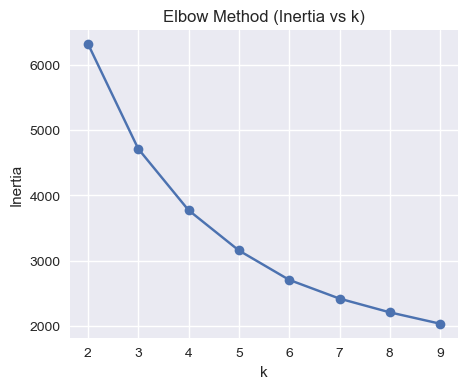

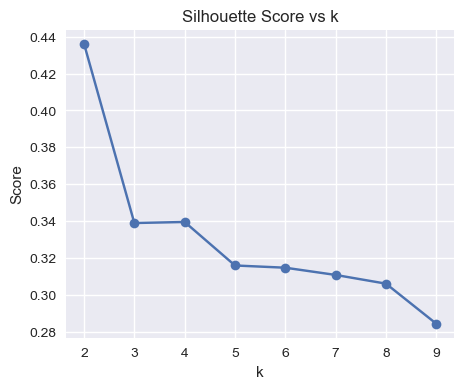

Best k by silhouette: 2
Chosen k for business segmentation: 3


In [10]:
K_RANGE = range(2, 10)
inertias, sil_scores = [], []

for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

# Plot Elbow
plt.figure(figsize=(5,4))
plt.plot(list(K_RANGE), inertias, marker="o")
plt.title("Elbow Method (Inertia vs k)")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.show()

# Plot Silhouette
plt.figure(figsize=(5,4))
plt.plot(list(K_RANGE), sil_scores, marker="o")
plt.title("Silhouette Score vs k")
plt.xlabel("k"); plt.ylabel("Score")
plt.show()

best_k_sil = int(list(K_RANGE)[np.argmax(sil_scores)])
print("Best k by silhouette:", best_k_sil)

# Force a business-driven choice
best_k = 3   # try 3 clusters even if silhouette suggested 2
print("Chosen k for business segmentation:", best_k)

In [11]:
km_final = KMeans(n_clusters=best_k, n_init=50, random_state=42)
labels = km_final.fit_predict(X)
rfm["Cluster"] = labels

**CONCLUDE**
- Cluster 0 → High frequency, high spend → VIP customers  
- Cluster 1 → Old, low frequency, low spend → Lost customers  
- Cluster 2 → Recent, moderate frequency, moderate spend → New customers  

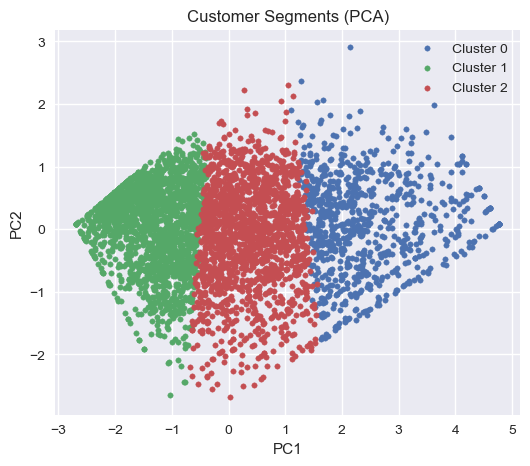

In [12]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,5))
for c in sorted(np.unique(labels)):
    plt.scatter(X_pca[labels==c,0], X_pca[labels==c,1], 
                s=15, label=f"Cluster {c}")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("Customer Segments (PCA)")
plt.legend()
plt.savefig(os.path.join(OUT_DIR,"pca_clusters.png"), dpi=150)
plt.show()

,Cluster,n_customers,recency_mean,frequency_mean,monetary_mean,Segment
0,0,798,16.679198,11.641604,5260.569478,"VIP Customers (High Frequency, High Spend)"
1,1,1875,165.126933,1.334400,351.612278,"Lost Customers (Low Spend, Old, Rare Purchases)"
2,2,1665,47.054054,3.362162,1248.182691,"New Customers (Recent, Moderate Spend)"


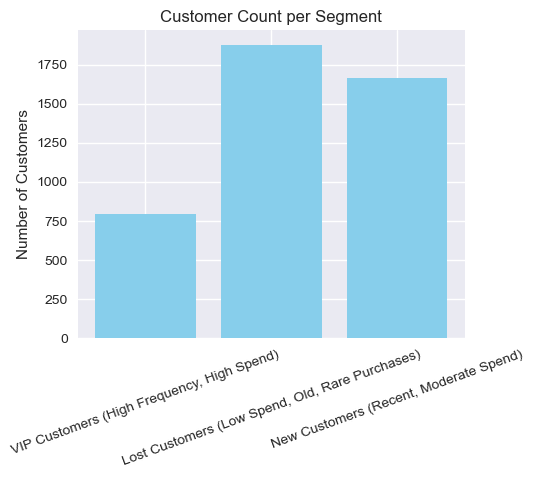

In [13]:
profile = rfm.groupby("Cluster").agg(
    n_customers=("CustomerID","count"),
    recency_mean=("Recency","mean"),
    frequency_mean=("Frequency","mean"),
    monetary_mean=("Monetary","mean"),
).reset_index()

# Manual business interpretation
cluster_map = {
    0: "VIP Customers (High Frequency, High Spend)",
    1: "Lost Customers (Low Spend, Old, Rare Purchases)",
    2: "New Customers (Recent, Moderate Spend)"
}
profile["Segment"] = profile["Cluster"].map(cluster_map)
display(profile)

# Bar chart of cluster sizes
plt.figure(figsize=(5,4))
plt.bar(profile["Segment"], profile["n_customers"], color="skyblue")
plt.title("Customer Count per Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=20)
plt.show()


In [14]:
N = min(300, X.shape[0])
idx = np.random.choice(X.shape[0], N, replace=False)
X_small = X[idx]

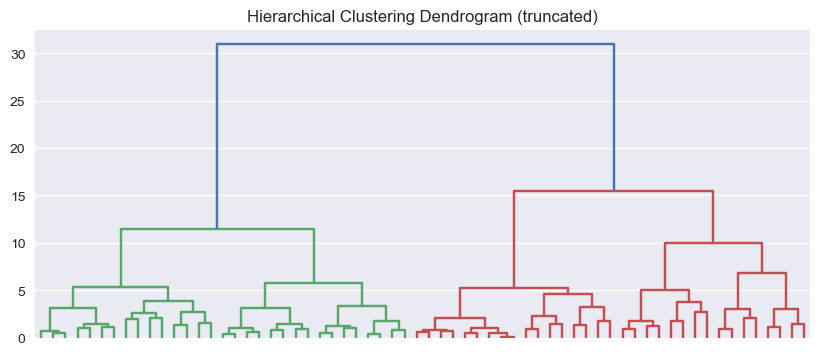

In [15]:
Z = linkage(X_small, method="ward")
plt.figure(figsize=(10,4))
dendrogram(Z, truncate_mode="level", p=5, no_labels=True)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.savefig(os.path.join(OUT_DIR,"dendrogram.png"), dpi=150)
plt.show()

✅ Conclusion

- Built RFM features from transactional data  
- Preprocessed via winsorization, log, scaling  
- Tuned KMeans clusters with **Elbow & Silhouette**  
- Visualized clusters with **PCA**  
- Profiled clusters & provided **business insights**  

📌 This workflow demonstrates a complete **Unsupervised Learning project** suitable for academic and industry applications.